In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, rgb2hex
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

import scipy.ndimage as ndimg

from cellpose import utils
from skimage.io import imread
import scipy
from skimage.morphology import binary_erosion, binary_dilation, medial_axis, disk, medial_axis,remove_small_holes,remove_small_objects
import skfmm
import cv2

import fastremap #important for relabeling! Could move just to color function perhaps, but idk of other parts of cellpose require sequential lebel matrices; probably worth it

n = 1
basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure images/'
basedir = basedir+'ecoli_phase_'+str(n)
maskdir = basedir+'_cp_masks.png'
phasedir =  basedir+ '.tif'
masks = imread(maskdir).astype(np.uint16)
phase = imread(phasedir)

from cellpose import models, io, dynamics, plot
import edt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


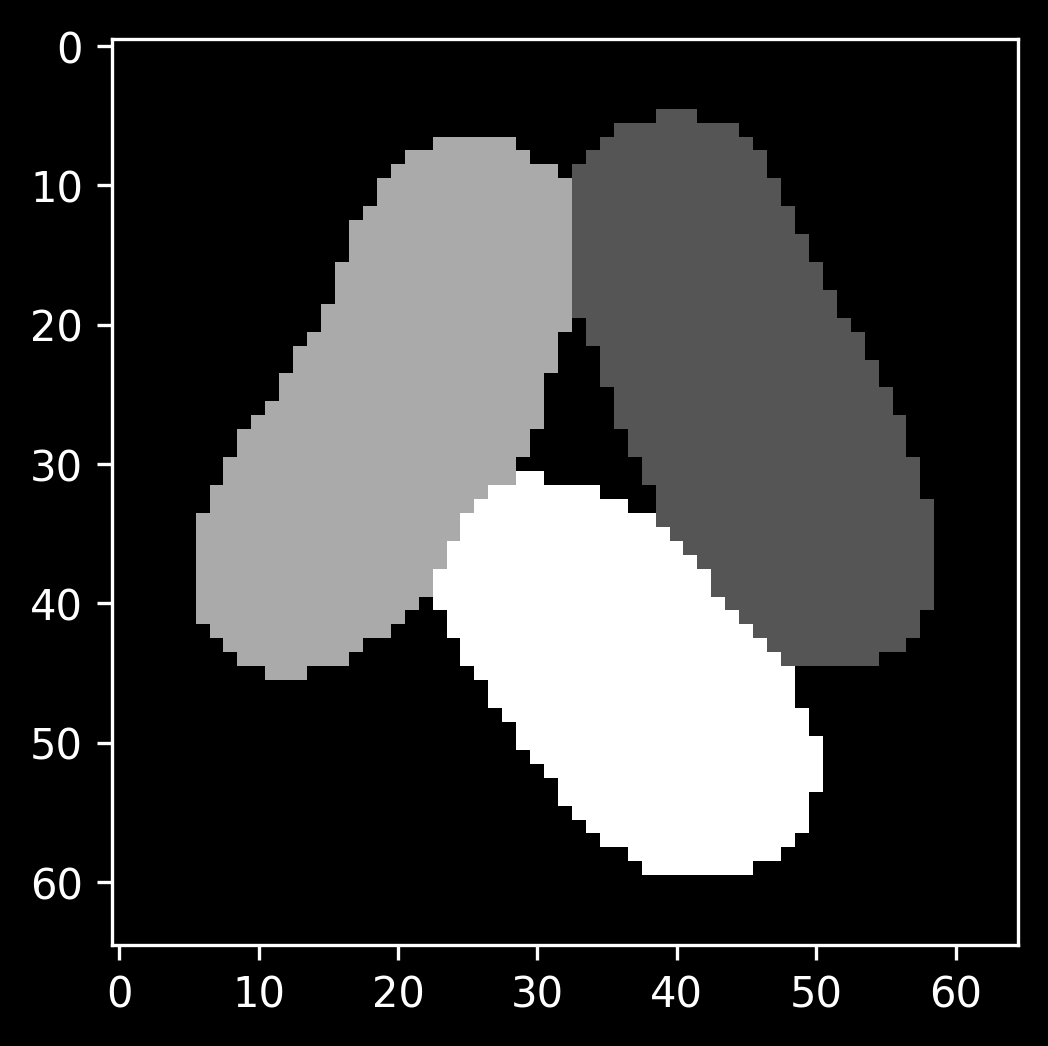

In [39]:
plt.imshow(masks)
pic = rescale(np.dstack([masks]*3))
io.imsave(basedir+'_masks_rgb.png',(pic*255).astype(np.uint8))

In [40]:
omni = False
if omni:
    suffix = '_OM'
else:
    suffix = '_CP'
labels,dists,heat,flows = dynamics.masks_to_flows(masks,use_gpu=0,omni=omni)
dy = flows[0,:,:]
dx = flows[1,:,:]

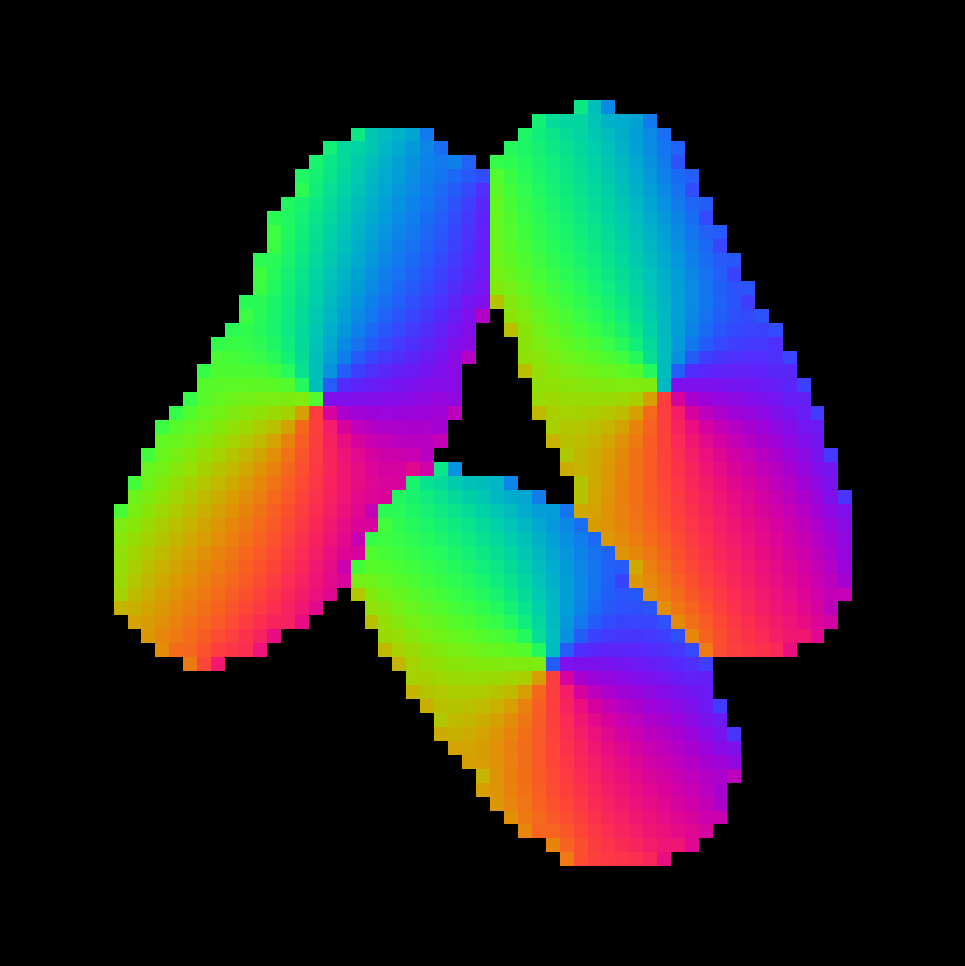

In [15]:
# pic = plot.dx_to_circ([dy,dx])
pic = plot.dx_to_circ([dy,dx],transparency=1)

# pic = rescale(heat)
plt.imshow(pic)
plt.axis('off')
plt.show()
# plt.imshow(np.arctan2(dy,dx))
# plt.imshow(np.logical_or(dx==0, dy==0))


In [16]:
# io.imsave('/home/kcutler/DataDrive/tle3TIFFs/d1/align/image_backup/frames/frame1_heatflow_grad_color.png', cv2.resize((pic*255).astype(np.uint8), dsize=(10*pic.shape[1],10*pic.shape[0]), interpolation=cv2.INTER_NEAREST))
# io.imsave('/home/kcutler/DataDrive/cephalexin/OG_omni_flow_training.png', cv2.resize((pic*255).astype(np.uint8), dsize=(10*pic.shape[1],10*pic.shape[0]), interpolation=cv2.INTER_NEAREST))
# io.imsave('/home/kcutler/DataDrive/neuronomniflow_original.png', cv2.resize((pic*255).astype(np.uint8), dsize=(10*pic.shape[1],10*pic.shape[0]), interpolation=cv2.INTER_NEAREST))
io.imsave(basedir+'_GT.png',(pic*255).astype(np.uint8))

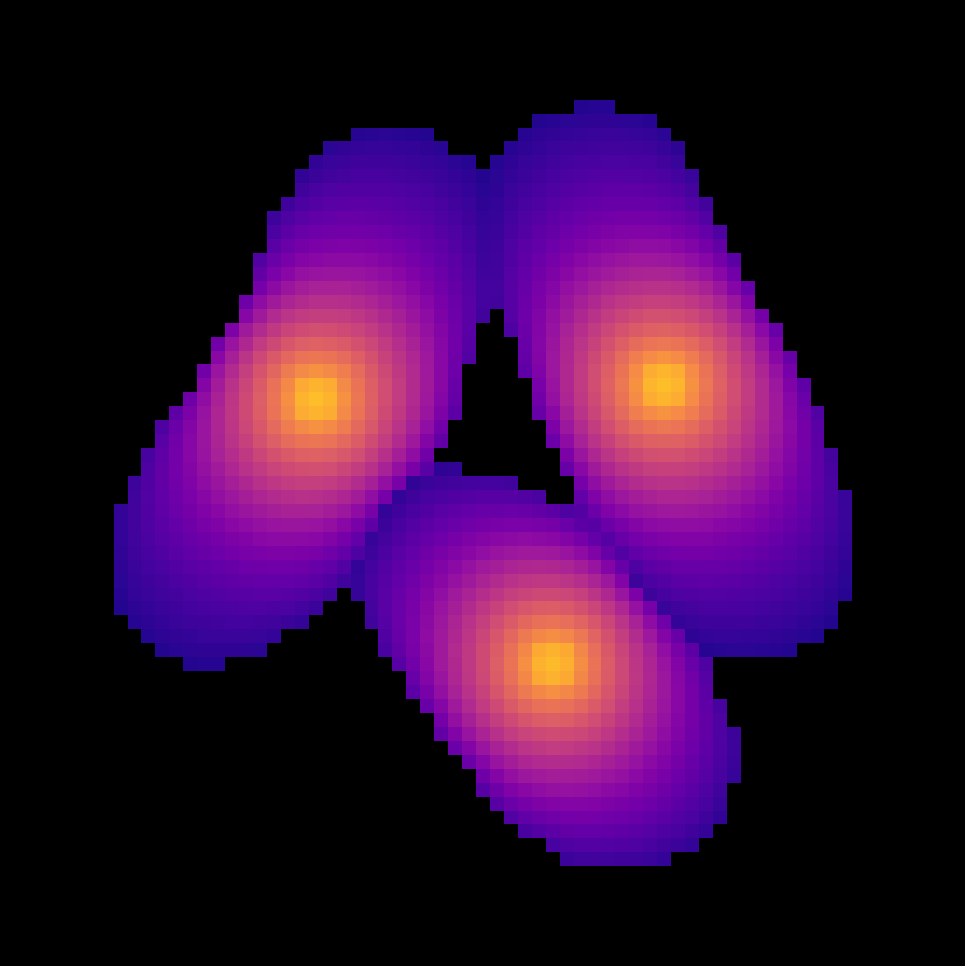

In [17]:
pic = 1-heat
io.imsave(basedir + '_heat.png',(pic*255).astype(np.uint8))
pic = 1-np.sqrt(heat)
io.imsave(basedir + '_sqheat.png',(pic*255).astype(np.uint8))

cmap = mpl.cm.get_cmap('plasma')
pic = cmap(np.sqrt(heat))
pic[:,:,-1] = masks>0
plt.imshow(pic)
plt.axis('off')
plt.show()
skimage.io.imsave(basedir + '_8bit_heat' + suffix + '.png',((pic)*255).astype(np.uint8))

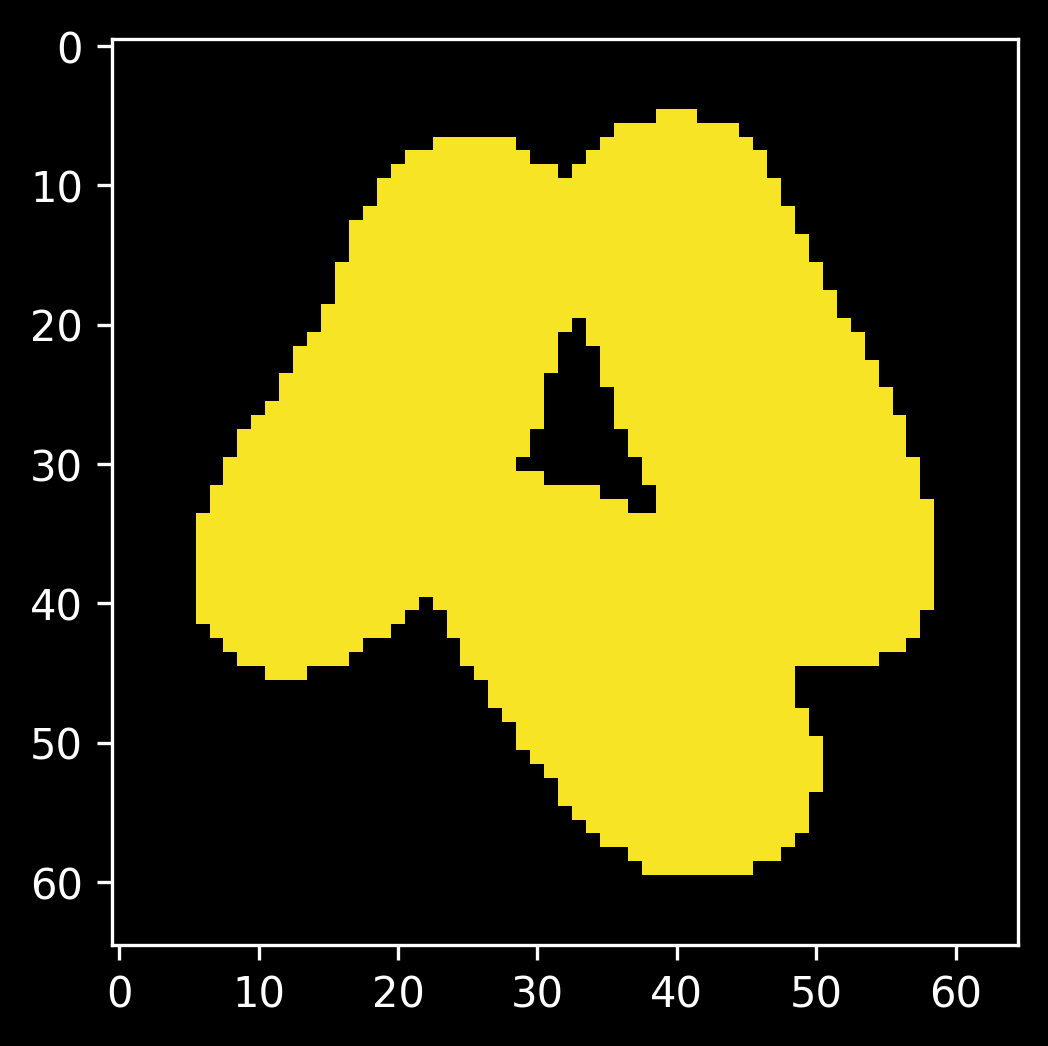

In [18]:
pic = 1-(masks>0)*.5
io.imsave(basedir + '_prob_GT.png',(pic*255).astype(np.uint8))
pic = 1-rescale(masks)
io.imsave(basedir + '_label_GT.png',(pic*255).astype(np.uint8))

cmap = mpl.cm.get_cmap('plasma')
pic = cmap(.95*(masks>0))
pic[:,:,-1] = masks>0
plt.imshow(pic)
skimage.io.imsave(basedir + '_color_prob' + suffix + '.png',((pic)*255).astype(np.uint8))

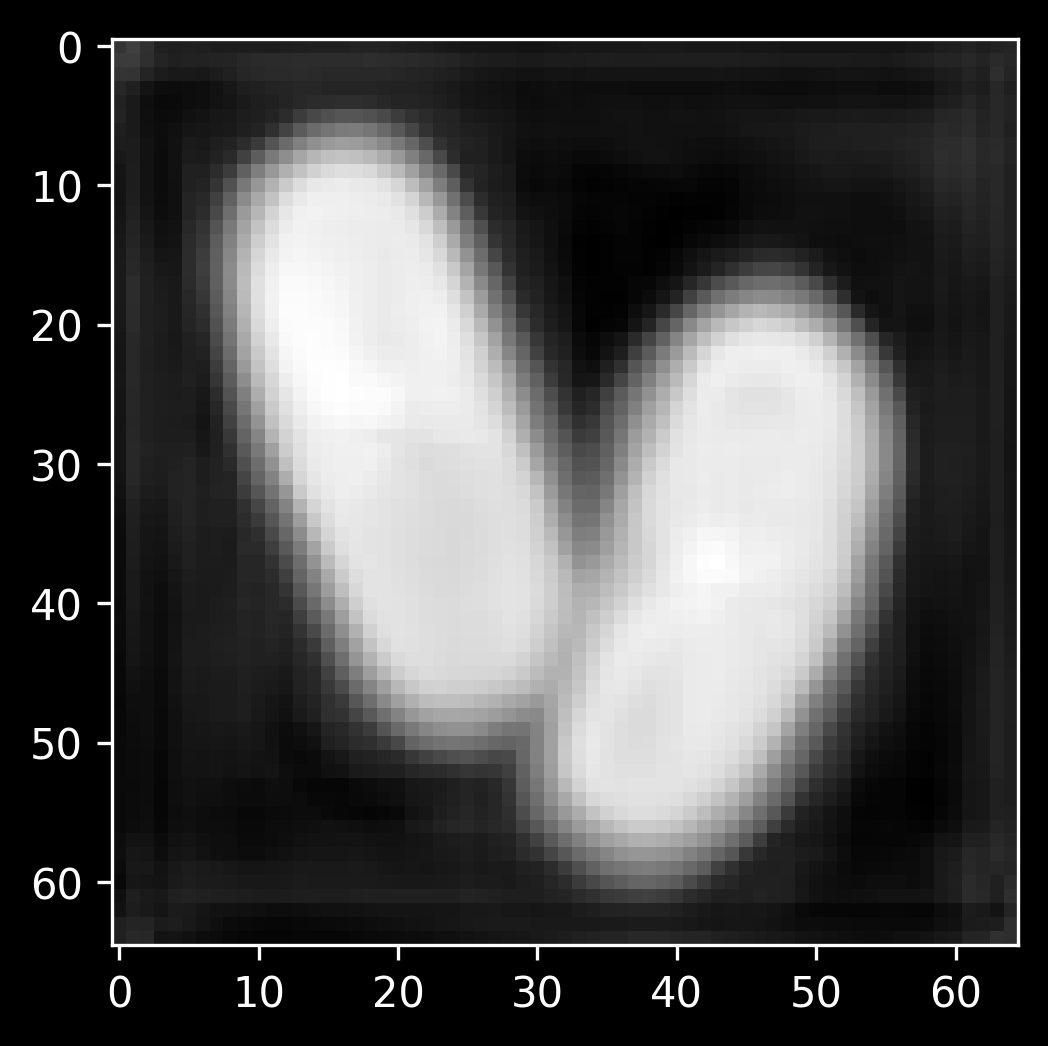

In [19]:
# name = 'dnaAmovie_t112c1'
# name = 'xy1crop2_t300c1'
# name = '022'
# name = '005'
# name = 'f_xy6c1'
# name = 'vibrio'
# name = 'bthai2'
name = 'caulo4'
# name = 'serra'
name = 'ec2'
# name = 'ec111'
# name = 'ect'
# name = 'ect2'
cellprob = imread('/home/kcutler/DataDrive/test/' + name + '_cellprob' + '.tif')
basedir =  '/home/kcutler/DataDrive/omnipose_paper/Figure 2/ecoli_phase_2'
plt.imshow(cellprob)

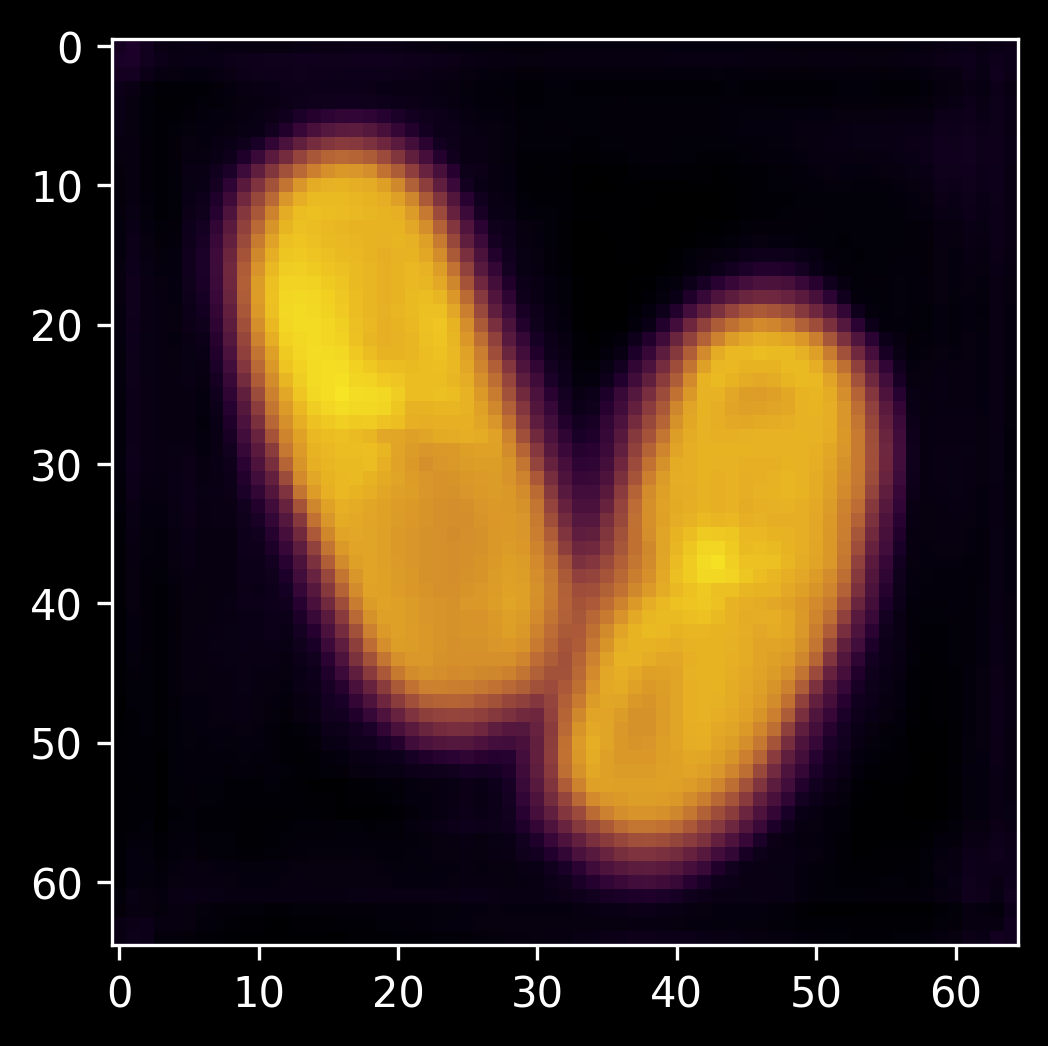

In [20]:
pic = 1-rescale(cellprob)*.5
io.imsave(basedir + '_prob_rgb.png',np.stack([pic*255]*3,axis=-1).astype(np.uint8))
io.imsave(basedir + '_prob-raw.tif',pic)
pic = 1-(cellprob>-1)*.25
io.imsave(basedir + '_prob_cutoff_rgb.png',np.stack([pic*255]*3,axis=-1).astype(np.uint8))


cmap = mpl.cm.get_cmap('plasma')
pic = cmap(.95*rescale(cellprob))
pic[:,:,-1] = rescale(cellprob)
plt.imshow(pic)
skimage.io.imsave(basedir + '_color_prob_predicted' + suffix + '.png',((pic)*255).astype(np.uint8))

(2, 65, 65)


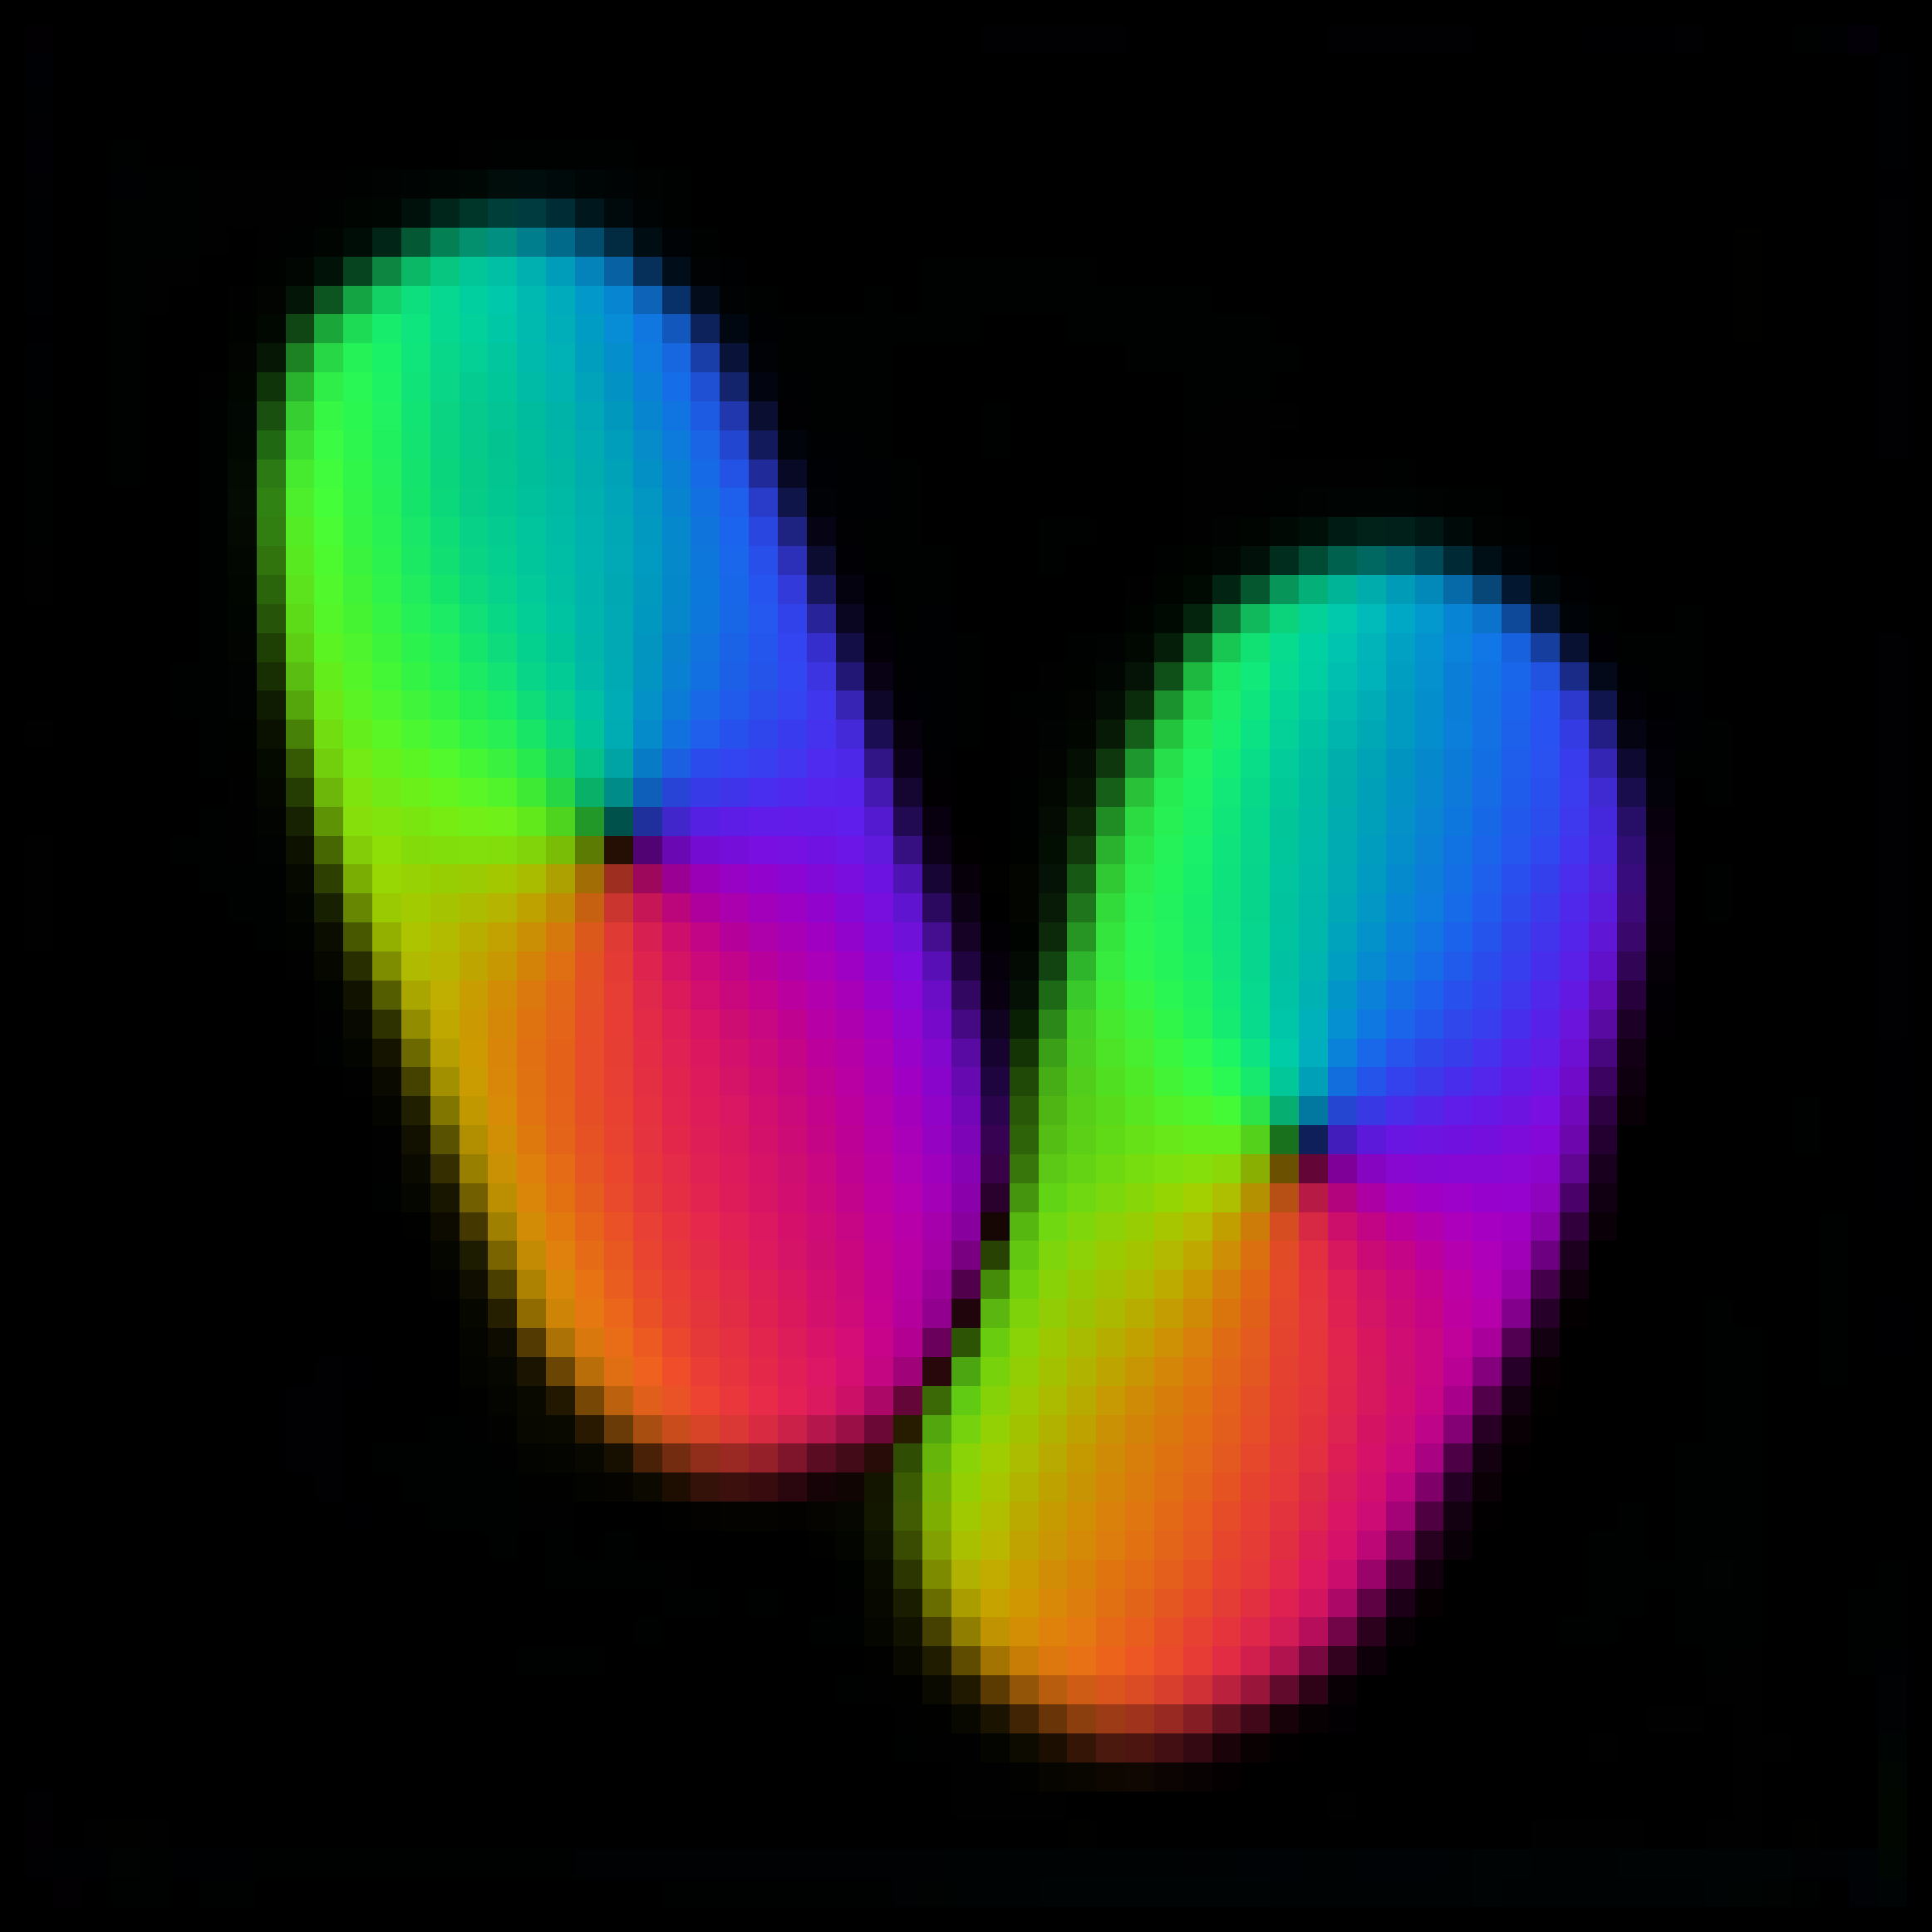

In [21]:
flows = imread('/home/kcutler/DataDrive/test/' + name + '_flows' + '.tif')
print(flows.shape)
plt.figure(figsize=(10,10))
dP = np.stack([flows[0,:,:],flows[1,:,:]])
plt.imshow(plot.dx_to_circ(dP,transparency=True))
plt.axis('off')
plt.show()

In [22]:
pic = plot.dx_to_circ([flows[0,:,:],flows[1,:,:]],transparency=True)
skimage.io.imsave(basedir + '_flow_big.png', cv2.resize((pic*255).astype(np.uint8), dsize=(10*pic.shape[1],10*pic.shape[0]), interpolation=cv2.INTER_NEAREST))
skimage.io.imsave(basedir + '_flow.png',(pic*255).astype(np.uint8))
#replace cellpose cv2 with skimage imsave for transparency 

io.imsave(basedir + '_Dx.tif',flows[1,:,:])
io.imsave(basedir + '_Dy.tif',flows[0,:,:])

In [23]:
masks = imread(basedir+'_cp_masks_OG.png')
masks = 1-rescale(masks)
io.imsave(basedir+'_cp_masks_OG_greyscale.png',(rescale(np.dstack([masks]*3))*255).astype(np.uint8))

In [26]:
omni=0
if omni:
    suffix = ''
else:
    suffix = '_OG'

# from cellpose import utils
masks, p, tr = dynamics.compute_masks(dP, cellprob, None, p=None, niter=200, mask_threshold=-1, diam_threshold=12.,
                                      flow_threshold=0.4, interp=True, cluster=False, do_3D=False, 
                                      min_size=15, resize=None, omni=omni, calc_trace=1, verbose=1)
np.any(masks)

2021-11-11 16:37:13,971 [INFO] mask_threshold is -1.000000


True

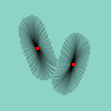

In [27]:
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline

A = 1.5
px = A/plt.rcParams['figure.dpi']  # pixel in inches

dists = edt.edt(masks)
bd = dists==1
Y,X = np.nonzero(bd) #boundary only
# select_inds = np.flatnonzero(masks)
a = 1
match = [np.any(np.logical_and((X-tr[1,i,0])**2<a,(Y-tr[0,i,0])**2<a)) for i in range(tr.shape[1])]
select_inds = np.argwhere(match).flatten()
lx = cellprob.shape[1]
ly = cellprob.shape[0]
# (tr[1,:,0]+1)*lx/2,X
# fig,ax = plt.subplots()
fig,ax = plt.subplots(figsize=(ly*px,lx*px))
ax.axis('off')
# ax.imshow()
ax.set_position([0, 0, 1, 1])
# ax.imshow(np.zeros((ly,lx,4)))
# plt.imshow(gt_flow)
# for i in range(tr.shape[1]):
for i in select_inds:
#     xs = (tr[1,i,:]+1)*lx/2
#     ys = (tr[0,i,:]+1)*ly/2
    xs = tr[1,i,:]
    ys = tr[0,i,:]
    ax.plot(xs,ys,c=[0,0,0,.25],solid_capstyle='round',linewidth=np.sqrt(A))


for i in range(tr.shape[1]):
    ax.plot(tr[1,i,-1],tr[0,i,-1],'r.',markersize=2*np.sqrt(A)*px*lx)
ax.set_xlim([0,lx])
ax.set_ylim([ly,0])
ax.patch.set_alpha(0.)
fig.patch.set_facecolor(None)
plt.show()
fig.savefig(basedir + '_perim_flows_' + suffix + '.svg',bbox_inches=0,transparent=True,pad_inches=0)
fig.savefig(basedir + '_perim_flows_' + suffix + '.pdf',bbox_inches='tight',transparent=True,pad_inches=0)

2021-11-11 16:37:17,802 [WARNING] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2021-11-11 16:37:17,802 [WARNING] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


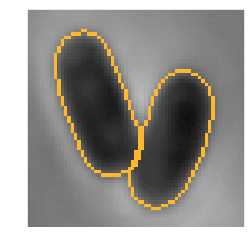

In [28]:
cmap = mpl.cm.get_cmap('plasma')
phasedir =  basedir + '.tif'
phase = imread(phasedir)
outline = plot.outline_view(phase/255,masks,color=cmap(.85)[:3])#,mode='thick')
plt.imshow(outline)
skimage.io.imsave(basedir + '_outlines'+suffix+'.png',(outline*(2**8-1)).astype(np.uint8))

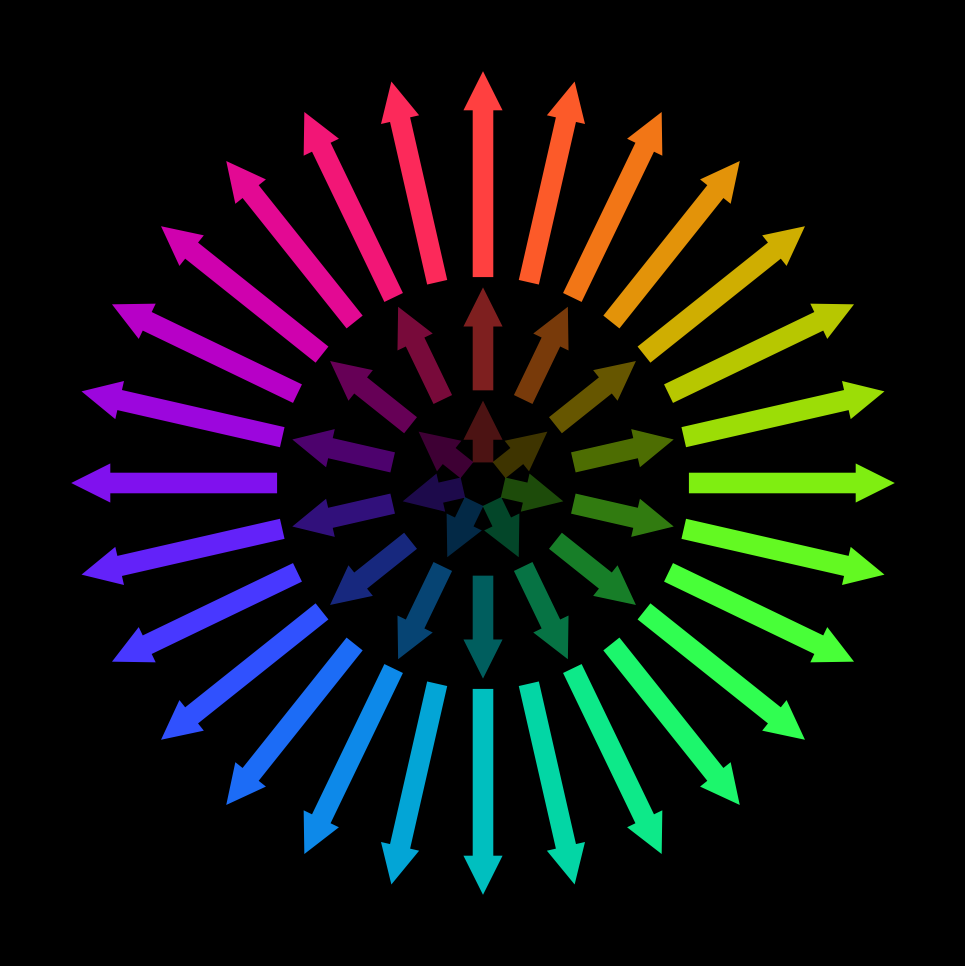

In [43]:
# flow legend
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')
rs = [[.1,.4],[.45,.95],[1,2]]
l = .19
n = [7,14,28]
d = [0,0,0]
for k in range(len(rs)):
    r1,r2 = rs[k]
    for theta in np.linspace(0,2*np.pi*(n[k]-1)/n[k],n[k]):
        theta+=d[k]
#         print(theta)
        r = ((np.cos(theta)+1)/2)
        g = ((np.cos(theta+2*np.pi/3)+1)/2)
        b = ((np.cos(theta+4*np.pi/3)+1)/2)
        
        theta =theta+np.pi/2
        ct = np.cos(theta)
        st = np.sin(theta)
        w = (r2-r1)
        plt.arrow(r1*ct,r1*st,(r2-r1)*ct,(r2-r1)*st,head_width=l,
                  head_length=l,length_includes_head=1,facecolor=[r,g,b,(r2-r1)], 
                  width=.1,edgecolor=[0,0,0,0])
basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure images/'
fig.savefig(os.path.join(basedir,'flow_legend.pdf'),bbox_inches='tight',transparent=True,pad_inches=0)